In [259]:
from Simulator.Tasks.Task import Task
from Simulator.Tasks.Requirements import Requirements
from Simulator.Machines.Resources import Resources
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv

import importlib
from gym import Env
from gym import spaces

import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt




import Simulator.ResSim 

In [295]:
Simulator.ResSim  = importlib.reload(Simulator.ResSim)

In [261]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [262]:
class SaveResults(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, list_avg_reward_save):
        super(SaveResults, self).__init__(1)
        self.avg_reward = list_avg_reward_save

    def _on_step(self) -> bool:
        # print("HERE")
        
        x, y = ts2xy(load_results("log/"), "timesteps")
        
        if len(x) > 0:
            if len(x) > 20:
                self.avg_reward.append((self.num_timesteps, np.mean(np.asarray(y[-20:]))))
            else:
                self.avg_reward.append((self.num_timesteps, y[-1]))

        return True

In [263]:
def create_sim():
    """ Method to create a sim and return it to keep the enviroment code clean"""
    
    # Create Traffic
    
    test_traffic = []
    for x in range(0, 500):
        if np.random.random() > 0.5:
            # test_traffic.append((x, Task(Requirements(), 10)))
            test_traffic.append((x, Task(Requirements(), 10)))
        elif np.random.random() > 0.5:
            test_traffic.append((x, Task(Requirements(cpus =2), 15)))
            # test_traffic.append((x, Task(Requirements(), 10)))
        
    sim = Simulator.ResSim.ResSim(test_traffic, lambda x: int(x.cpus == 2), [Resources(), Resources(), Resources(cpus=2, power_level = 2)], 2)
    return sim

In [264]:
class SimEnv(Env):
    def __init__(self):
        """ Init the sim enviroment """
        super(SimEnv, self).__init__()
        self.sim = create_sim()
        # self.action_space = 
        # self.observation_space = len(self.sim.getState())
        self.action_space = spaces.Discrete(self.sim.getActionDem())
        self.observation_space = spaces.Box(low=-1.0, high=2.0,
                                        shape=(len(self.sim.getState()), ), dtype=np.float64)
        self.results = []
        self.avg_results = []
        self.episode_return = []
        self.episodes = 0 
        self.episode_avg_task_per_timestep = []
        self.avg_episode_avg_task_per_timestep = []
        self.episode_curTime = []
        self.avg_episode_curTime = []
    
    def step(self, action):
        """ Take the action """
        reward = self.sim.doAction(action)
        # print(action)
        info = {}
        self.results.append(reward)            
            
        if self.sim.done:
            num_completed = len(self.sim.sysLogger.completed_tasks)
            self.episode_avg_task_per_timestep.append(num_completed / self.sim.curTime)
            self.episode_curTime.append(self.sim.curTime)
            
            self.episode_return.append(np.sum(self.results))
            if len(self.episode_return) > 20:
                self.avg_results.append(np.mean(self.episode_return[-20:]))
                self.avg_episode_curTime.append(np.mean(self.episode_curTime[-20]))
                self.avg_episode_avg_task_per_timestep.append(np.mean(self.episode_avg_task_per_timestep[-20]))
            else:
                self.avg_results.append(np.sum(self.results))
                self.avg_episode_avg_task_per_timestep.append(num_completed / self.sim.curTime)
                self.avg_episode_curTime.append(self.sim.curTime)
            self.episodes += 1
            # print(self.sim.num_completed_tasks)
        # if reward != -100:
        #     print(reward)
        return self.sim.getState(), reward, self.sim.done, info
        # Todo
    
    # def render(self, action):
    #     # Blank
    
    def reset(self):
        self.results = []
        """ Reset the enviroment"""
        self.sim = create_sim()
        return self.sim.getState()
    
    def close(self):
        """Closing"""
        print("All done")
        

In [265]:
%%time
env = Monitor(SimEnv(), "log/")
baseline = DQN(
    "MlpPolicy", 
    env, 
    verbose=0, 
    buffer_size = 1000, 
    batch_size = 64,
    gamma = 0.99,
    train_freq= 1,
    learning_starts = 1000,
    target_update_interval = 100,
    exploration_fraction = 1,
    exploration_final_eps = 0.01,
    exploration_initial_eps = 1,
    learning_rate = 0.002,
    policy_kwargs= {'net_arch': [400, 400]}
)
avg_reward_baseline = []
baseline.learn(900000, callback = SaveResults(avg_reward_baseline))


CPU times: user 40min 3s, sys: 9min 44s, total: 49min 47s
Wall time: 41min 3s


Text(0, 0.5, 'Moving Average Return (20 Episodes)')

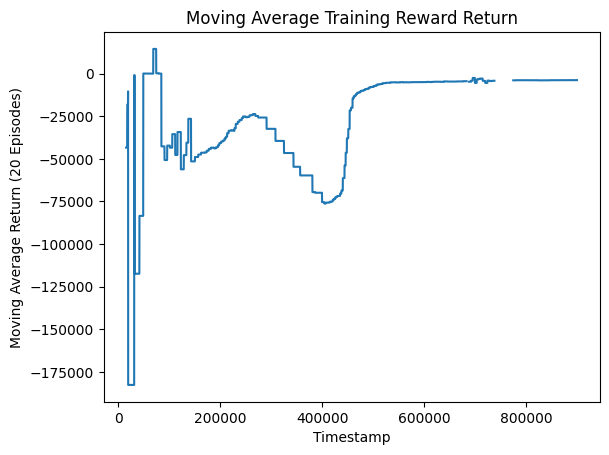

In [266]:
avg_reward_baseline_2 = np.array(avg_reward_baseline)
plt.plot(avg_reward_baseline_2[:, 0], avg_reward_baseline_2[:, 1],label="Standard Baseline")
plt.title("Moving Average Training Reward Return")
plt.xlabel("Timestamp")
plt.ylabel("Moving Average Return (20 Episodes)")
# plt.legend()

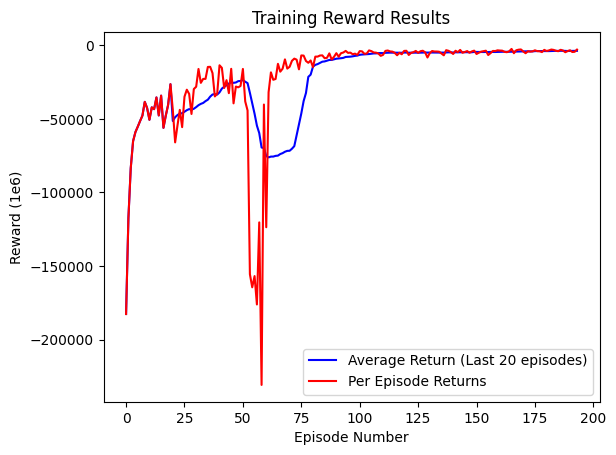

In [283]:
plt.plot(env.avg_results[:],'b',label="Average Return (Last 20 episodes)")
plt.plot(env.episode_return[:], 'r', label = "Per Episode Returns")
plt.title("Training Reward Results")
plt.xlabel("Episode Number")
plt.ylabel("Reward (1e6)")
a = plt.legend()

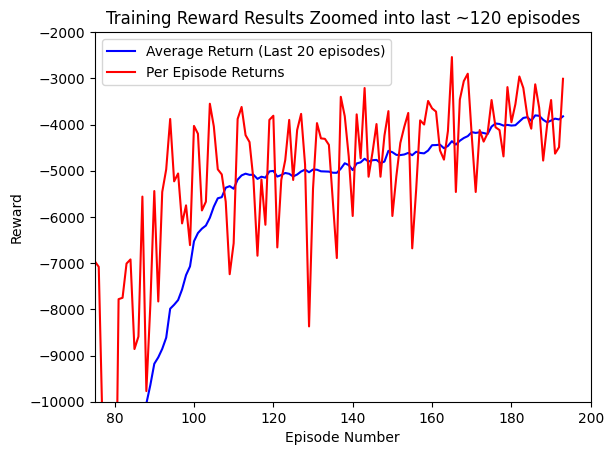

In [294]:
plt.plot(env.avg_results[:],'b',label="Average Return (Last 20 episodes)")
plt.plot(env.episode_return[:], 'r', label = "Per Episode Returns")
plt.title("Training Reward Results Zoomed into last ~120 episodes")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.xlim(75, 200)
plt.ylim(-10000, -2000)
a = plt.legend()

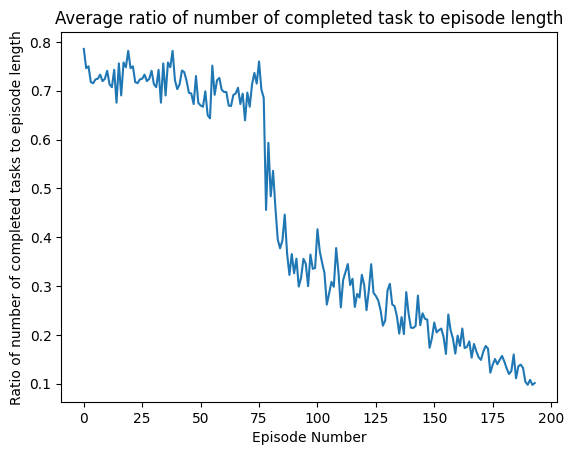

In [271]:
plt.plot(env.avg_episode_avg_task_per_timestep[:])
plt.title("Average ratio of number of completed task to episode length")
plt.ylabel("Ratio of number of completed tasks to episode length")
_ = plt.xlabel("Episode Number")


Text(0, 0.5, 'Number of timesteps within the episode')

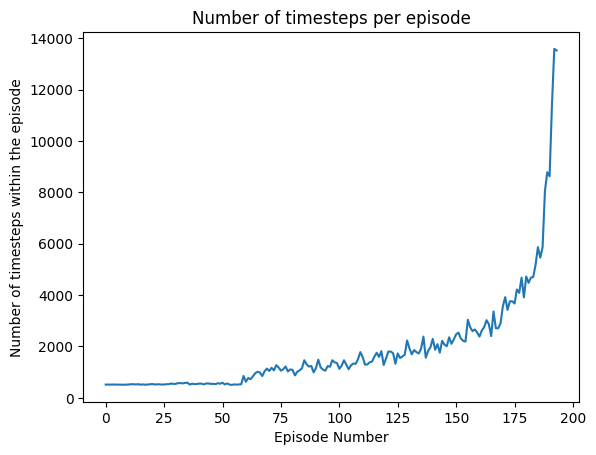

In [272]:
plt.plot(env.episode_curTime)
plt.title("Number of timesteps per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number of timesteps within the episode")

# Trying reward at the time of adding task

In [276]:
%%time
env2 = Monitor(SimEnv(), "log/")
baseline = DQN(
    "MlpPolicy", 
    env2, 
    verbose=0, 
    buffer_size = 1000, 
    batch_size = 64,
    gamma = 0.99,
    train_freq= 1,
    learning_starts = 1000,
    target_update_interval = 100,
    exploration_fraction = 1,
    exploration_final_eps = 0.01,
    exploration_initial_eps = 1,
    learning_rate = 0.002,
    policy_kwargs= {'net_arch': [400, 400]}
)
avg_reward_baseline2 = []
baseline.learn(900000, callback = SaveResults(avg_reward_baseline2))


CPU times: user 38min 24s, sys: 9min 41s, total: 48min 6s
Wall time: 39min 23s


In [ ]:
avg_reward_baseline_3 = np.array(avg_reward_baseline2)
plt.plot(avg_reward_baseline_3[:, 0], avg_reward_baseline_3[:, 1],label="Standard Baseline")
plt.title("Moving Average Training Reward Return")
plt.xlabel("Timestamp")
plt.ylabel("Moving Average Return (20 Episodes)")
# plt.legend()

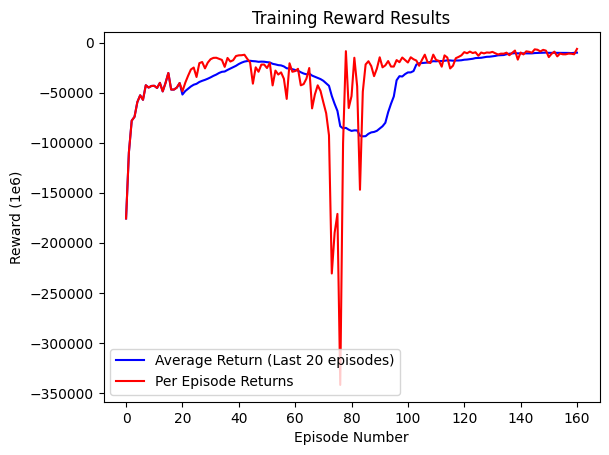

In [278]:
# plt.plot(moving_average(env.results, 20))
# plt.plot(env.results,'^',label="Return")
plt.plot(env2.avg_results[:],'b',label="Average Return (Last 20 episodes)")
plt.plot(env2.episode_return[:], 'r', label = "Per Episode Returns")
plt.title("Training Reward Results")
plt.xlabel("Episode Number")
plt.ylabel("Reward (1e6)")
a = plt.legend()

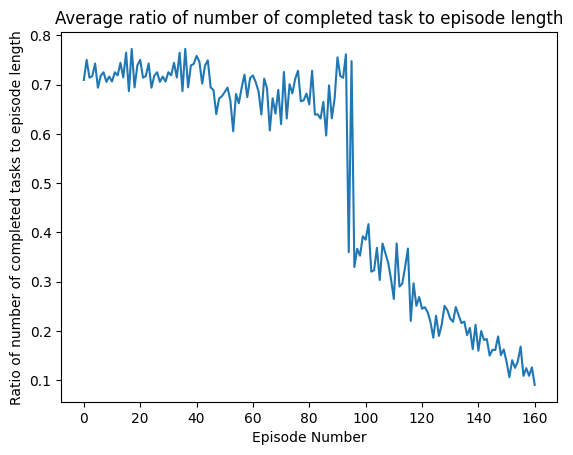

In [279]:
plt.plot(env2.avg_episode_avg_task_per_timestep[:])
plt.title("Average ratio of number of completed task to episode length")
plt.ylabel("Ratio of number of completed tasks to episode length")
_ = plt.xlabel("Episode Number")


Text(0, 0.5, 'Number of timesteps within the episode')

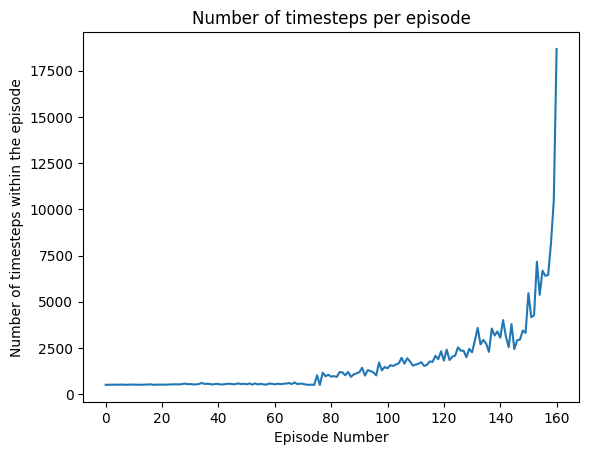

In [280]:
plt.plot(env2.episode_curTime)
plt.title("Number of timesteps per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number of timesteps within the episode")